In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import cartopy.crs  as ccrs
import os
import datetime
from datetime import timedelta
from datetime import datetime
from matplotlib import ticker
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import geopandas as gp
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from scipy import stats
from scipy.stats import linregress
import matplotlib.patches as patches
from scipy.stats import linregress
import WetBulb
import pymannkendall as mk

GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [2]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

def standardize(x):
    return x/x.std(dim = 'time')

def CtoF(x):
    return x*9/5 + 32

# Load trend data

In [3]:
data_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'
grid_slope_30C = np.loadtxt(data_dir + "trend_30C_days_km.txt", delimiter=",")
grid_slope_90th = np.loadtxt(data_dir + "trend_90th_days_km.txt", delimiter=",")

grid_pval_30C = np.loadtxt(data_dir + "30C_days_trend_pvalue_km.txt", delimiter=",")
grid_pval_90th = np.loadtxt(data_dir + "90th_days_trend_pvalue_km.txt", delimiter=",")

In [4]:
# Historical temperature data
file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

filenames = []

years_array = np.arange(1979,2023,1)

for year in years_array:
    
    if year <= 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_PBE_historical_an-sfc_' + str(year) + '_0UTC.nc'
    
    if year > 1958:
        
        file_name = file_dir + 'T_daily_max_ERA5_historical_an-sfc_' + str(year) + '_0UTC.nc'
        
    filenames.append(file_name)

# Open all files
temp_dailymax = xr.open_mfdataset(filenames)

In [5]:
temp_dailymax = temp_dailymax.rename_vars({'T': 't2m'})

In [6]:
# Just open 2023 data

file_dir = '/dx01/data/ERA5/2mtemp_dailymax/'

temp_2023 = xr.open_mfdataset(file_dir + 'T_daily_max_ERA5_historical_an-sfc_2023_0UTC.nc')

In [7]:
# Combine ERA5 and ERA5T
temp2023_ERA5 = temp_2023.sel(expver=1)

temp2023_ERA5T = temp_2023.sel(expver = 5)

In [8]:
temp2023_ERA5 = temp2023_ERA5.isel(time = slice(0, 304))
temp2023_ERA5T = temp2023_ERA5T.isel(time = slice(304,366))

In [9]:
temp2023_combined = xr.combine_by_coords([temp2023_ERA5,temp2023_ERA5T])

In [10]:
# Historical data
temp_combined = xr.combine_by_coords([temp_dailymax,temp2023_combined.drop_vars('expver')])

In [11]:
temp_reg = temp_combined.sel(latitude = slice(8,-37), longitude = slice(-75+360, -32+360))

In [12]:
# Find station data
stn_folder = '/dx01/ivanov/data/HadISD_stationdata/brazil_heatwave/raw_station_data/'

# Rio stations
galeao_name = 'hadisd.3.4.0.2023f_19310101-20240101_837460-99999.nc'
galeao = xr.open_dataset(stn_folder + galeao_name)

In [13]:
# Grid cell closest to Rio station location
lon_grid, lat_grid = np.meshgrid(temp_combined.longitude.values, temp_combined.latitude.values)
distances = np.sqrt((lon_grid - (galeao.longitude.values + 360))**2 + (lat_grid - galeao.latitude.values)**2)
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

# Get the longitude and latitude of the closest grid cell
closest_lon = temp_combined.longitude.values[min_index[1]]
closest_lat = temp_combined.latitude.values[min_index[0]]

temp_toplot = temp_combined.sel(latitude = [closest_lat], longitude = [closest_lon]).mean(dim = ['latitude','longitude'])

In [14]:
temp_toplot.load()

<xarray.Dataset>
Dimensions:  (time: 16436)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-12-31
Data variables:
    t2m      (time) float32 307.1 302.5 304.2 298.9 ... 303.3 309.4 302.3 298.1

In [15]:
# Start with ERA5 data for Rio specifically
rio_temp = temp_toplot.t2m

thresh = 30
ERA5_T_above_thresh = rio_temp[rio_temp > thresh + 273.15]

# Only select days in spring
abovethresh_spring = ERA5_T_above_thresh.sel(time = ERA5_T_above_thresh.time.dt.month.isin([9,10,11]))
spring_counts_abovethresh = abovethresh_spring.groupby(abovethresh_spring.time.dt.year).count()

In [16]:
# Generate mask
file = '/dx01/data/ERA5/time_invariant/land_sea_mask.nc'
sftlf_ref = xr.open_dataset(file).mean(dim = "time")

temp_ocean = temp_reg.where(sftlf_ref.lsm < 0.4, drop=True).mean(dim= 'time')

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
temp_ocean.load()

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 136)
Coordinates:
  * latitude   (latitude) float64 8.0 7.75 7.5 7.25 ... -36.5 -36.75 -37.0
  * longitude  (longitude) float64 285.0 285.2 285.5 285.8 ... 327.5 327.8 328.0
Data variables:
    t2m        (longitude, latitude) float32 nan nan nan ... 290.0 289.8 289.7

# Figure 7

In [18]:
fig = plt.figure(figsize = (15,3.75), dpi = 1200)

gs = fig.add_gridspec(1,3)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(), facecolor = 'w', frame_on = True)
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[2])

cmap = plt.cm.get_cmap("autumn_r")
cmap.set_under(color='limegreen')    

### Trend map for 30 degree days
mesh1 = ax1.pcolormesh(temp_reg.longitude, temp_reg.latitude, grid_slope_30C.transpose(), vmin = 0, vmax = 3, cmap = cmap)
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
ax1.coastlines(linewidth=2, zorder = 11)
ax1.add_feature(cfeature.BORDERS)
ax1.set_xticks([-72,-62, -52,-42, -32])
ax1.set_yticks([-35,-25,-15,-5,5]);
ax1.set_xlim([-75,-32])
ax1.set_ylim([-37,8])
ax1.set_title('Days Above 30C', fontweight = 'bold')
ax1.contourf(temp_ocean.longitude,temp_ocean.latitude, 0*temp_ocean.t2m.transpose(), levels = np.arange(0,1,0.001), cmap = 'Greys', zorder = 10)

p1 = plt.Rectangle((-75, -37), 75-32, 37+8, fill=False, linewidth = 1,edgecolor = 'k', zorder = 12)
ax1.add_patch(p1)

# Add stippling
sig_mask_30C = grid_pval_30C < 0.05
unsig_30C = ~np.array(sig_mask_30C)
unsig_plot_30C = unsig_30C.astype(int)

[m_30C,n_30C] = np.where(unsig_plot_30C > 0)

z1_30C=np.zeros(unsig_plot_30C.shape)
z1_30C[m_30C, n_30C] = 99

cs_30C = ax1.contourf(temp_reg.longitude, temp_reg.latitude, z1_30C.transpose(), 3, color = 'grey',hatches=['', '..'], linestyles = None, alpha = 0)

### Trend map for 90th percentile days
mesh2 = ax2.pcolormesh(temp_reg.longitude, temp_reg.latitude, grid_slope_90th.transpose(), vmin = 0, vmax = 3, cmap = cmap)
ax2.set_xlabel('Longitude')
ax2.coastlines(linewidth=2, zorder = 10)
ax2.add_feature(cfeature.BORDERS)
ax2.set_xticks([-72,-62, -52,-42, -32])
ax2.set_yticks([-35,-25,-15,-5,5]);
ax2.set_xlim([-75,-32])
ax2.set_ylim([-37,8])
ax2.set_title('Days Above 90th Percentile', fontweight = 'bold')
ax2.contourf(temp_ocean.longitude,temp_ocean.latitude, 0*temp_ocean.t2m.transpose(), levels = np.arange(0,1,0.001), cmap = 'Greys', zorder = 10)

p2 = plt.Rectangle((-75, -37), 75-32, 37+8, fill=False, linewidth = 1,edgecolor = 'k', zorder = 12)
ax2.add_patch(p2)

# Add stippling
sig_mask_90th = grid_pval_90th < 0.05
unsig_90th = ~np.array(sig_mask_30C)
unsig_plot_90th = unsig_90th.astype(int)

[m_90th,n_90th] = np.where(unsig_plot_90th > 0)

z1_90th=np.zeros(unsig_plot_90th.shape)
z1_90th[m_90th, n_90th] = 99

cs_90th = ax2.contourf(temp_reg.longitude, temp_reg.latitude, z1_90th.transpose(), 3, hatches=['', '..'], color = 'grey',linestyles = None, alpha = 0)

cbar = plt.colorbar(mesh2, ax = fig.axes[0:2], shrink = 0.75, format = '%.1f', label = 'Trend in Extreme Frequency\n(days/year)', pad = 0.05, extend = 'both')

### Trend in days above 30C or days above 90th percentile for Rio
rio_spring_result = mk.original_test(spring_counts_abovethresh)

# Create a scatter plot of the data
ax3.scatter(spring_counts_abovethresh.year[:-1], spring_counts_abovethresh[:-1], label = 'Data', color = 'grey')
ax3.scatter(spring_counts_abovethresh.year[-1], spring_counts_abovethresh[-1], label = 'Data', color = 'crimson')

# Plot the linear regression line
ax3.plot(spring_counts_abovethresh.year, rio_spring_result.slope * (spring_counts_abovethresh.year-1979) + rio_spring_result.intercept, color='k', label='Linear Fit')

ax3.set_xlabel('Year')
ax3.set_ylabel('Days >30C during SON')

ax3.text(1978,48,'slope = ' + str(np.round(rio_spring_result.slope,2)), ha = 'left', ma = 'center', backgroundcolor = 'white', fontsize = 10, zorder = 8)
ax3.text(1978,45,'p = ' + str(np.round(rio_spring_result.p,2)), ha = 'left', ma = 'center', backgroundcolor = 'white', fontsize = 10, zorder = 8)
ax3.text(2016,48.2,'2023', ha = 'left', ma = 'center',color = 'crimson', fontweight = 'bold',fontsize = 10, zorder = 8)

# Add A, B, C markers
import string

ax1.text(-80, 9, string.ascii_lowercase[0], size=20, weight='bold')
ax2.text(-80, 9, string.ascii_lowercase[1], size=20, weight='bold')
ax3.text(1973, 54, string.ascii_lowercase[2], size=20, weight='bold')

plt.savefig('/home/ivanov/jupyternb/Brazil_Heatwave/Final Figures for Upload/Figure7.png')

plt.show()

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("autumn_r"))
  if __name__ == '__main__':
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecation

# Load correlation data

In [19]:
data_dir = '/dx02/data/ivanov/data/ERA5/Brazil_Heatwave/'

grid_corr_30C = np.loadtxt(data_dir + "ENSO_corr_90th_days.txt", delimiter=",")
grid_corr_90th = np.loadtxt(data_dir + "ENSO_corr_30C_days.txt", delimiter=",")

data_dir2 = '/dx03/data/ivanov/Brazil_Heatwave_revisions/'

grid_corr_rval_30C = np.loadtxt(data_dir2 + "ENSO_corr_90th_rvalue_OISST_NINO34.txt", delimiter=",")
grid_corr_rval_90th = np.loadtxt(data_dir2 + "ENSO_corr_30C_rvalue_OISST_NINO34.txt", delimiter=",")

grid_corr_pval_30C = np.loadtxt(data_dir2 + "ENSO_corr_90th_pvalue_OISST_NINO34.txt", delimiter=",")
grid_corr_pval_90th = np.loadtxt(data_dir2 + "ENSO_corr_30C_pvalue_OISST_NINO34.txt", delimiter=",")

In [20]:
# Open csv with ENSO indices
save_dir = '/dx03/data/ivanov/Brazil_Heatwave_revisions/'
nino34_index = xr.open_dataarray(save_dir + 'nino34_index_1981-2023.nc')

In [21]:
# Select just winter and spring data
box_spring = temp_toplot.sel(time = temp_toplot.time.dt.month.isin([9,10,11])).t2m

In [22]:
# Calculate number of days above threshold each year
thresh = 30 + 273.15

def counts_above_thresh(x, thresh):
    
    years = np.unique(x.time.dt.year.values)

    counts_above = []

    for year in years:

        annual_data = x.sel(time = x.time.dt.year == year)
        annual_counts = len(annual_data[annual_data > thresh])
        counts_above.extend([annual_counts])
        
    return counts_above

In [23]:
spring_counts = counts_above_thresh(box_spring.sel(time = box_spring.time.dt.year >= 1981), thresh)

ENSO_spring = nino34_index.sel(time = nino34_index.time.dt.month.isin([9,10,11]))
ENSO_annualSON = ENSO_spring.groupby('time.year').mean()

# Figure S8

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1459: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = self._pcolormesh_patched(*args, **kwargs)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is depr

Text(-2.7, 54, 'c')

/opt/sw/anaconda3/2023.09/envs/pangeoxtd36/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


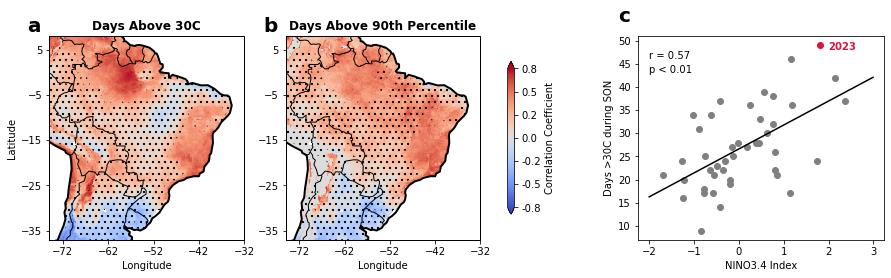

In [24]:
fig = plt.figure(figsize = (15,3.75)) #, dpi = 1200

gs = fig.add_gridspec(1,3)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(), facecolor = 'w', frame_on = True)
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[2])  

### Trend map for 30 degree days
mesh1 = ax1.pcolormesh(temp_reg.longitude, temp_reg.latitude, grid_corr_rval_30C.transpose(), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm')
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
ax1.coastlines(linewidth=2, zorder = 11)
ax1.add_feature(cfeature.BORDERS)
ax1.set_xticks([-72,-62, -52,-42, -32])
ax1.set_yticks([-35,-25,-15,-5,5]);
ax1.set_xlim([-75,-32])
ax1.set_ylim([-37,8])
ax1.set_title('Days Above 30C', fontweight = 'bold')
ax1.contourf(temp_ocean.longitude,temp_ocean.latitude, 0*temp_ocean.t2m.transpose(), levels = np.arange(0,1,0.001), cmap = 'Greys', zorder = 10)

p1 = plt.Rectangle((-75, -37), 75-32, 37+8, fill=False, linewidth = 1,edgecolor = 'k', zorder = 12)
ax1.add_patch(p1)

# Add stippling
sig_mask_30C = grid_corr_pval_30C < 0.05
unsig_30C = ~np.array(sig_mask_30C)
unsig_plot_30C = unsig_30C.astype(int)

[m_30C,n_30C] = np.where(unsig_plot_30C > 0)

z1_30C=np.zeros(unsig_plot_30C.shape)
z1_30C[m_30C, n_30C] = 99

cs_30C = ax1.contourf(temp_reg.longitude, temp_reg.latitude, z1_30C.transpose(), 3, color = 'grey',hatches=['', '..'], linestyles = None, alpha = 0)

### Trend map for 90th percentile days
mesh2 = ax2.pcolormesh(temp_reg.longitude, temp_reg.latitude, grid_corr_rval_90th.transpose(), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm')
ax2.set_xlabel('Longitude')
ax2.coastlines(linewidth=2, zorder = 10)
ax2.add_feature(cfeature.BORDERS)
ax2.set_xticks([-72,-62, -52,-42, -32])
ax2.set_yticks([-35,-25,-15,-5,5]);
ax2.set_xlim([-75,-32])
ax2.set_ylim([-37,8])
ax2.set_title('Days Above 90th Percentile', fontweight = 'bold')
ax2.contourf(temp_ocean.longitude,temp_ocean.latitude, 0*temp_ocean.t2m.transpose(), levels = np.arange(0,1,0.001), cmap = 'Greys', zorder = 10)

p2 = plt.Rectangle((-75, -37), 75-32, 37+8, fill=False, linewidth = 1,edgecolor = 'k', zorder = 12)
ax2.add_patch(p2)

# Add stippling
sig_mask_90th = grid_corr_pval_90th < 0.05
unsig_90th = ~np.array(sig_mask_30C)
unsig_plot_90th = unsig_90th.astype(int)

[m_90th,n_90th] = np.where(unsig_plot_90th > 0)

z1_90th=np.zeros(unsig_plot_90th.shape)
z1_90th[m_90th, n_90th] = 99

cs_90th = ax2.contourf(temp_reg.longitude, temp_reg.latitude, z1_90th.transpose(), 3, hatches=['', '..'], color = 'grey',linestyles = None, alpha = 0)

cbar = plt.colorbar(mesh2, ax = fig.axes[0:2], shrink = 0.75, format = '%.1f', label = 'Correlation Coefficient', pad = 0.05, extend = 'both')

### Trend in days above 30C or days above 90th percentile for Rio

x_range = np.arange(-2,3,0.01)

ax3.scatter(ENSO_annualSON[:-1], spring_counts[:-1],color = 'grey')
ax3.scatter(ENSO_annualSON.values[-1], spring_counts[-1],color = 'crimson')

ax3.set_xlabel('NINO3.4 Index')
ax3.set_ylabel('Days >30C during SON')

slope, intercept, r_value, p_value, std_err = linregress(np.squeeze(ENSO_annualSON), spring_counts)

# Plot the linear regression line
ax3.plot(x_range, slope * x_range + intercept, color='k', label='Linear Fit')
ax3.text(-2,46,'r = ' + str(np.round(r_value,2)), ha = 'left', ma = 'center', backgroundcolor = 'white', fontsize = 10, zorder = 8)
ax3.text(-2,43,'p < 0.01', ha = 'left', ma = 'center', backgroundcolor = 'white', fontsize = 10, zorder = 8)
ax3.text(2,48,'2023', ha = 'left', ma = 'center',color = 'crimson', fontweight = 'bold',fontsize = 10, zorder = 8)

ax1.text(-80, 9, 'a', size=20, weight='bold')
ax2.text(-80, 9, 'b', size=20, weight='bold')
ax3.text(-2.7, 54, 'c', size=20, weight='bold')

#plt.savefig('figures8.png')